In [1]:
import torch
import torch.nn as nn
import os

import yaml
from pathlib import Path


import numpy as np
from openmm.app import *
from openmm import *
from openmm.unit import *


from sys import stdout

from simutils import ForceReporter, ForceModelConvert
from maputils import EquiValReporter

import training_modules as tm

from traj_reporter import TrajectoryReporter

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset , DataLoader
from training_utils import CGDataset , TrainSystem


/home/enere@usi.ch/miniconda3/envs/CGffap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import yaml
import numpy as np
from pathlib import Path
from cgmap.utils import DataDict
from cgmap.mapping import Mapper

from typing import Dict

from aggforce import linearmap as lm
from aggforce import agg as ag
from aggforce import constfinder as cf

In [3]:
# Assign directory
input_directory = 'StartingStructures'

output_directory = 'TargetSimDir/ChignolinTutorial'

##
OpenMM Generate Simulation

In [4]:
# Iterate over files in directory
for name in os.listdir(input_directory):
        file = os.path.join(input_directory, name)
        print(file)
        pdb = PDBFile(file)

        forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
        system = forcefield.createSystem(pdb.topology, nonbondedMethod=NoCutoff,
                 constraints=HBonds)
        
        integrator = VerletIntegrator( 0.002*picoseconds)  #310*kelvin, 1/picosecond,
        simulation = Simulation(pdb.topology, system, integrator)
        simulation.context.setPositions(pdb.positions)
        simulation.minimizeEnergy()
        print(system.usesPeriodicBoundaryConditions())
        simulation.reporters.append(PDBReporter(output_directory + '/'+ name.split('.')[0] + '.pdb' , 50))
        simulation.reporters.append(TrajectoryReporter(output_directory + '/'+ name.split('.')[0] + '.dat', 50, step=True, potentialEnergy=True,
                kineticEnergy=True, temperature=True, time=True, totalEnergy=True))
        simulation.reporters.append(ForceReporter(output_directory + '/'+ name.split('.')[0] + '.txt', 50))
        simulation.minimizeEnergy()
        simulation.step(5000)
        forces = simulation.reporters[2].getForces()
        state = simulation.context.getState(getPositions=True, getEnergy=True, getForces=True)
        trrreport = simulation.reporters[1]
        trrreport.dump(output_directory + '/'+ name.split('.')[0] + '.pdb', output_directory + '/'+ name.split('.')[0] + '.trr')
        print(name + ' done')
        


StartingStructures/chignolin_frames0.pdb
False
chignolin_frames0.pdb done


In [13]:
input_pdb = os.path.join(os.getcwd(),output_directory, name)

In [10]:
trj_list = []
current_path = os.getcwd()


for name in os.listdir(output_directory):
    if name.endswith(".trr"):
        trj_list.append(os.path.join(current_path,output_directory, name))
    # if name.endswith(".pdb"):
    #     input_pdb = os.path.join(current_path,output_directory, name)

print(trj_list)

['/home/enere@usi.ch/latestmodel/CGffap/TargetSimDir/ChignolinTutorial/chignolin_frames0.trr']


In [14]:
print(input_pdb)

/home/enere@usi.ch/latestmodel/CGffap/TargetSimDir/ChignolinTutorial/chignolin_frames0.CG.xtc


In [20]:
config = {
    'mapping': 'martini3',
    'isatomistic': True,
    'input': '/home/enere@usi.ch/latestmodel/CGffap/TargetSimDir/ChignolinTutorial/chignolin_frames0.pdb',
    'inputtraj': trj_list[0],
    'selection': 'protein', # select protein from pdb
    'output': 'Chignolin_CG_Unfolded.pdb',
    'outputtraj': 'pdb',
    # 'trajslice': slice(1,101)
}


# Map atoms to beads (only protein for now)
mapping = Mapper(config)
mapping.map()
# mapping.save()
dataset = mapping.dataset

# force_set = forces[:,162]



Missing TYR_H2 in mapping file
Missing TYR_H3 in mapping file
Missing TYR_OXT in mapping file


In [23]:
dataset.keys()

for k,v in dataset.items():
    print(k)

num_residues
resnames
residcs
resnumbers
num_atoms
atom_pos
atom_resnames
atom_names
atom_types
atom_residcs
atom_resnumbers
ATOM_SEGIDS
atom_forces
num_beads
bead_pos
bead_idnames
bead_resnames
bead_names
bead_types
bead_residcs
bead_resnumbers
bead_segids
bead_forces
pbc
bead2atom_idcs
bead2atom_weights
bond_indices
angle_indices
improper_dih_indices
bead_charges
bead_charge_dict


In [16]:
# dataset = dict(np.load('/storage_common/angiod/chignolin_unfolded/chignolin.data.A.kcal.npz', allow_pickle=True))
pos2unit = 1.
eng2unit = 1.

In [22]:
equvalrep = EquiValReporter(dataset=dataset)

equvalrep.bondMapper(config_file_path="config/bond_config.yaml")
equvalrep.angleMapper(conf_angles_path="test_conf/config.angles.yaml")
equvalrep.improperDihedralMapper(conf_angles_path="test_conf/config.dihedrals.yaml")
equvalrep.beadChargeMapper()
# equvalrep.reportEquiVals(reportPath='test_conf/')

conf_bonds:        dict = equvalrep.getBonds()
conf_angles:       dict = equvalrep.getAngles()
conf_dihedrals:    dict = equvalrep.getImproperDihs()
conf_bead_charges: dict = equvalrep.getBeadCharges()

Side Chain Bond Matrix Shape (54, 2)
All bonds Mat Shape (72, 2)
Bonds to be removed [] Bonds to be replaced with correct value []
Number of issued found: 0
Number of issues remain: 0


In [24]:
dataset['bond_indices']

array([[ 0,  1],
       [ 0,  5],
       [ 1,  2],
       [ 1,  4],
       [ 2,  3],
       [ 3,  4],
       [ 5,  6],
       [ 5, 10],
       [ 6,  7],
       [ 6,  9],
       [ 7,  8],
       [ 8,  9],
       [10, 11],
       [10, 12],
       [12, 13],
       [12, 14],
       [14, 15],
       [14, 16],
       [16, 17],
       [16, 18],
       [18, 19],
       [19, 20],
       [19, 21],
       [21, 22],
       [21, 27],
       [22, 23],
       [22, 24],
       [23, 24],
       [24, 25],
       [24, 26],
       [25, 26],
       [27, 28],
       [28, 29],
       [28, 31],
       [29, 30],
       [30, 31]])

In [ ]:
model_weights = 'models/chignolin.A.kcal.bond.fixed.best.pth'
model_weights = None

system = TrainSystem(
    dataset,
    conf_bonds,
    conf_angles,
    conf_dihedrals,
    conf_bead_charges,
    model_weights=model_weights,
    pos2unit=pos2unit,
    eng2unit=eng2unit,
    num_bead_types=42,
)

model = system.initiateTraining(
    epochs=10,
    batch_size=100,
    patience=50,
    lr=1.e-2,
    checkpoint_every=None,
    model_name='chignolin.A.kcal.bond.fixed',
    device='cuda:2',
    )

In [8]:
import os
import numpy as np

from datetime import datetime
from pathlib import Path
from openmm.app import *
from openmm import *
from openmm.unit import kelvin, picoseconds

from simutils import ForceReporter, build_system

In [9]:
args_dict = {
    'mapping': 'martini3',
    'input': input_pdb,
    'selection': 'protein and not resname NME',
    'isatomistic': True,        # If the input pdb is an atomistic pdb, set this to True. It will save a CG version and load it in OpenMM
    'pos2unit': AngstromsPerNm,  # If the model works in Angstrom use this, if it works in nm just comment this line
    'energy2unit': KJPerKcal,    # If the model works in Kcal use this, if it works in KJ just comment this line
    'model': 'models/chignolin.A.kcal.best.pt', # Path to the compiled model saved after training
    'sim_folder': 'simulations', # Save simulation and logs inside this folder
    'log_every': 100,            # Log every N simulation steps
    'steps': 10000,              # Simulation steps
}

In [10]:
system, pdb = build_system(args_dict)

/home/enere@usi.ch/miniconda3/envs/CGffap/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
Missing TYR_BB in mapping file
Missing TYR_SC1 in mapping file
Missing TYR_SC2 in mapping file
Missing TYR_SC4 in mapping file
Missing TYR_SC3 in mapping file
Missing TYR_BB in mapping file
Missing TYR_SC1 in mapping file
Missing TYR_SC2 in mapping file
Missing TYR_SC4 in mapping file
Missing TYR_SC3 in mapping file
Missing ASP_BB in mapping file
Missing ASP_SC1 in mapping file
Missing PRO_BB in mapping file
Missing PRO_SC1 in mapping file
Missing GLU_BB in mapping file
Missing GLU_SC1 in mapping file
Missing THR_BB in mapping file
Missing THR_SC1 in mapping file
Missing GLY_BB in mapping file
Missing THR_BB in mapping file
Missing THR_SC1 in mapping file
Missing TRP_BB in mapping file
Missing TRP_SC1 in mapping file
Missing TRP_SC2 in ma

ValueError: need at least one array to concatenate

In [37]:
mapping.dataset.keys()
mapping.save()

/home/enere@usi.ch/miniconda3/envs/CGffap/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


In [36]:
current_dir = os.getcwd()

output_file = os.path.join(current_dir, "dataset.ChigUnfolded.npz")
np.savez(output_file, **dataset)
print(f"{output_file} successfully saved!")

/home/enere@usi.ch/CGffap/dataset.ChigUnfolded.npz successfully saved!


In [3]:
dataset = dict(np.load('dataset.ChigUnfolded.npz', allow_pickle=True))  #0.239006 / 100

In [4]:
np.linalg.norm(dataset['bead_pos'][0,1] - dataset['bead_pos'][0,0])

0.2821158942813462

In [5]:
# dataset['bead_pos'] = dataset['bead_pos']/10

In [6]:
np.where(np.linalg.norm(dataset['atom_forces'],axis=-1) == np.linalg.norm(dataset['atom_forces'],axis=-1).max(axis=0))


(array([   0,    0,    1, ..., 9998, 9999, 9999]),
 array([54, 84, 54, ..., 84, 54, 84]))

In [7]:
np.linalg.norm(dataset['atom_forces'],axis=-1).max(-1).shape

(10000,)

In [8]:
dataset['atom_forces']

array([[[ 6.47429810e+01, -3.20297943e+02,  1.86942730e+01],
        [ 1.46207123e+01,  4.04190025e+01, -6.39317703e+01],
        [ 1.20321722e+01, -4.40511017e+01, -2.13643646e+01],
        ...,
        [ 1.90297527e+01,  3.11918087e+01,  2.89518471e+01],
        [ 4.16951256e+01, -5.79457712e+00,  4.58963203e+00],
        [-4.29088707e+01,  2.29536438e+00, -6.06781769e+00]],

       [[ 5.41248665e+01, -3.15963715e+02, -3.34677315e+01],
        [-2.45765543e+00,  3.66168404e+01, -6.02685928e+01],
        [ 9.27050781e+00, -4.62633400e+01, -1.38248625e+01],
        ...,
        [ 1.91303387e+01,  3.29365082e+01,  3.27449455e+01],
        [ 3.80951500e+01, -9.85076904e-01,  1.24313154e+01],
        [-4.26085396e+01,  4.84045076e+00, -1.08037271e+01]],

       [[ 4.56980972e+01, -3.13831451e+02, -3.51945877e+01],
        [-1.98774242e+01,  4.75401649e+01, -6.47459259e+01],
        [ 1.29838018e+01, -4.56930046e+01, -7.94535542e+00],
        ...,
        [ 1.22415428e+01,  2.81715145e+01,

In [9]:
# dataset['atom_pos'] = dataset['atom_pos'] /10
dataset['bead_pos'] = dataset['bead_pos'][:40000]
dataset['bead_forces'] = dataset['bead_forces'][:40000]


In [10]:
dataset['bead_forces'].shape

(10000, 32, 3)

In [11]:
equvalrep = EquiValReporter(dataset=dataset)

equvalrep.bondMapper(config_file_path="config/bond_config.yaml")
equvalrep.angleMapper(conf_angles_path="test_conf/config.angles.yaml")
equvalrep.improperDihedralMapper(conf_angles_path="config/config.naive.per.bead.type.dihedrals.yaml")
equvalrep.beadChargeMapper()

Side Chain Bond Matrix Shape (54, 2)
All bonds Mat Shape (72, 2)
Bonds to be removed [] Bonds to be replaced with correct value []
Number of issued found: 0
Number of issues remain: 0


True

In [12]:
# equvalrep.reportEquiVals(reportPath='test_conf/')

In [13]:
dataset = equvalrep.getDataset()

# print(dataset['bead_forces'][:].sum(axis=-1).sum(axis=-1))

# dataset['bead_forces'] = (dataset['bead_forces'][:,:,:] - (dataset['bead_forces'][:,:,:].sum(axis=1)/len(dataset['bead_types']))[:,None,:])

# print(dataset['bead_forces'][:].sum(axis=-1).sum(axis=-1))

In [14]:
conf_bonds: dict = equvalrep.getBonds()
conf_angles: dict = equvalrep.getAngles()
conf_dihedrals: dict = equvalrep.getImproperDihs()
conf_bead_charges: dict = equvalrep.getBeadCharges()

In [15]:
system = TrainSystem(dataset, conf_bonds, conf_angles, conf_dihedrals, conf_bead_charges)


/home/enere@usi.ch/CGffap/training_modules.py:110: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1711323198313/work/torch/csrc/utils/tensor_new.cpp:261.)
  self.bead_charges_vals = torch.nn.Parameter(torch.reshape(torch.Tensor([i for i in conf_bead_charges.values()]).float().to(self.device), (-1,)))


In [16]:
dataset['bead_idnames']

array(['TYR_BB', 'TYR_SC1', 'TYR_SC2', 'TYR_SC4', 'TYR_SC3', 'TYR_BB',
       'TYR_SC1', 'TYR_SC2', 'TYR_SC4', 'TYR_SC3', 'ASP_BB', 'ASP_SC1',
       'PRO_BB', 'PRO_SC1', 'GLU_BB', 'GLU_SC1', 'THR_BB', 'THR_SC1',
       'GLY_BB', 'THR_BB', 'THR_SC1', 'TRP_BB', 'TRP_SC1', 'TRP_SC2',
       'TRP_SC3', 'TRP_SC5', 'TRP_SC4', 'TYR_BB', 'TYR_SC1', 'TYR_SC2',
       'TYR_SC4', 'TYR_SC3'], dtype='<U7')

In [17]:


model = system.initiateTraining(dataset = dataset, train_steps=3000, batch_size=32, patience=10, model_name= "Testtangles")
 
# 76.10421064232399


Epoch 1: Train Loss = 282310.740, Val Loss = 904379.311, Zero Loss Train = 262887.250, Zero Loss Val = 262887.250
Epoch 2: Train Loss = 266978.438, Val Loss = 265415.390, Zero Loss Train = 262887.250, Zero Loss Val = 262887.250
Epoch 3: Train Loss = 265435.945, Val Loss = 263655.032, Zero Loss Train = 262887.250, Zero Loss Val = 262887.250
Epoch 4: Train Loss = 264246.574, Val Loss = 262019.450, Zero Loss Train = 262887.250, Zero Loss Val = 262887.250
Epoch 5: Train Loss = 263519.615, Val Loss = 261395.965, Zero Loss Train = 262887.250, Zero Loss Val = 262887.250
Epoch 6: Train Loss = 262978.872, Val Loss = 260804.691, Zero Loss Train = 262887.250, Zero Loss Val = 262887.250
Epoch 7: Train Loss = 262480.381, Val Loss = 260229.076, Zero Loss Train = 262887.250, Zero Loss Val = 262887.250
Epoch 8: Train Loss = 262202.719, Val Loss = 259747.698, Zero Loss Train = 262887.250, Zero Loss Val = 262887.250
Epoch 9: Train Loss = 261930.581, Val Loss = 259684.267, Zero Loss Train = 262887.250, Z

KeyboardInterrupt: 

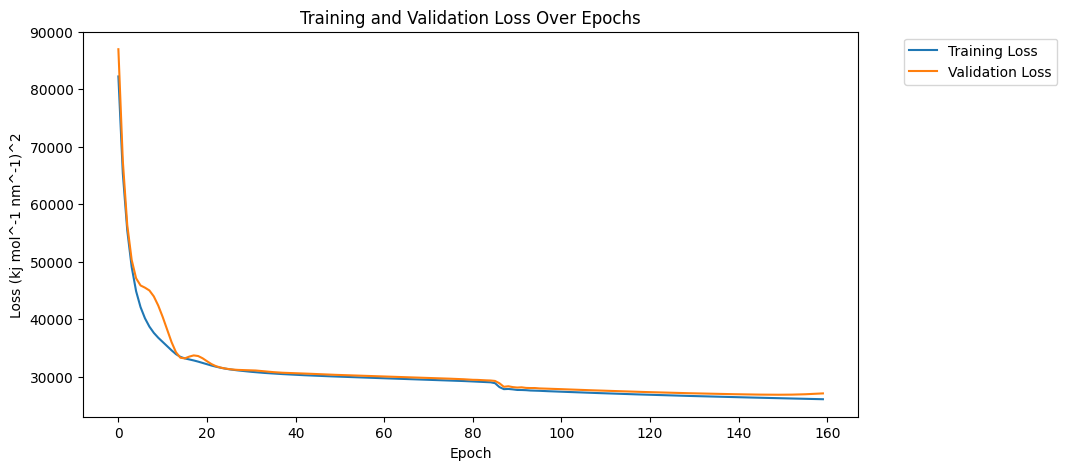

In [23]:
system.plotLosses(truncate=1)

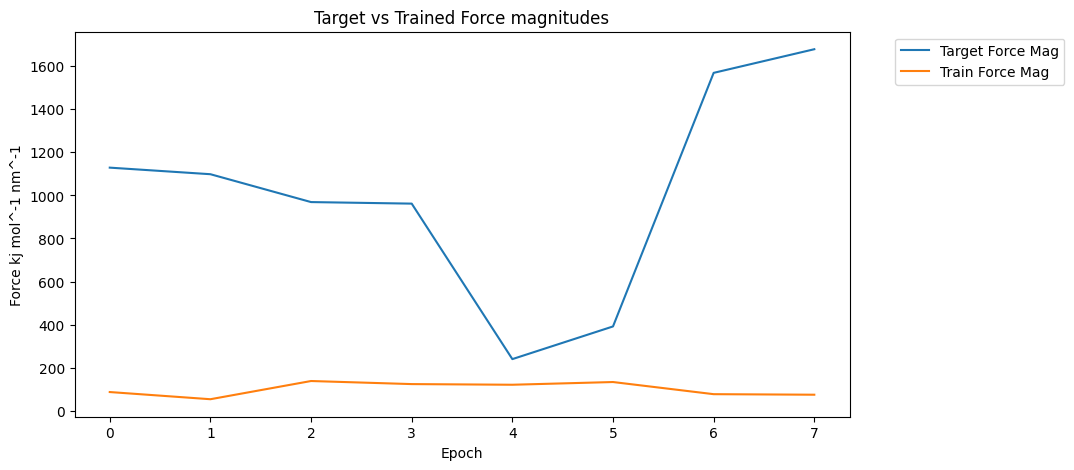

In [51]:
system.plotForceMagnitudeMatching(bead_index=1, to_frame=8)

<Figure size 1000x500 with 0 Axes>

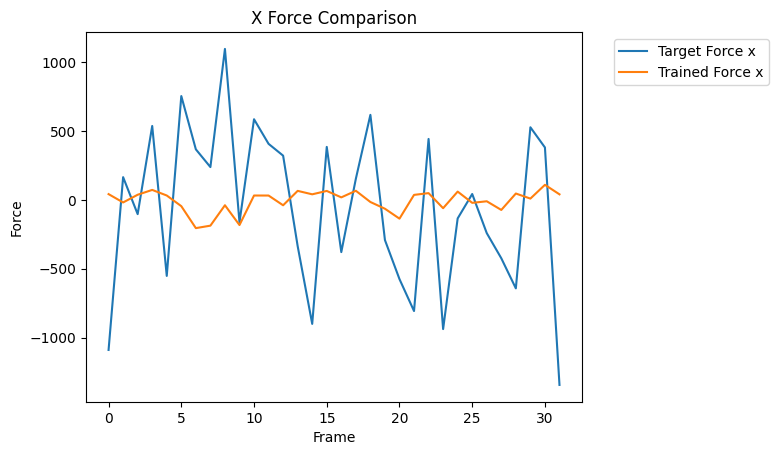

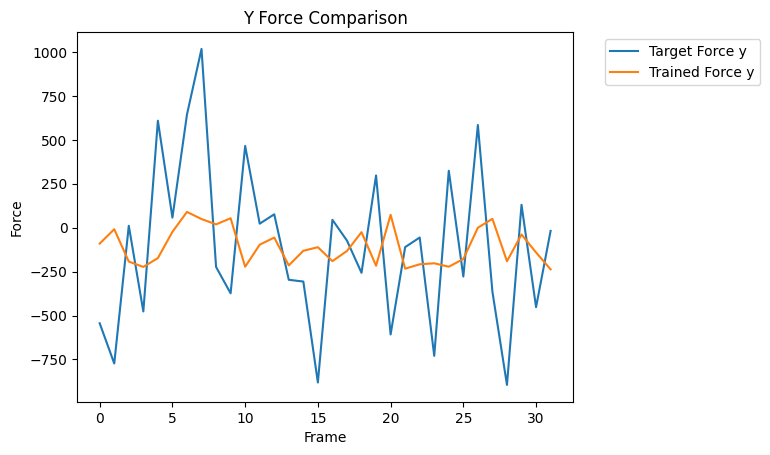

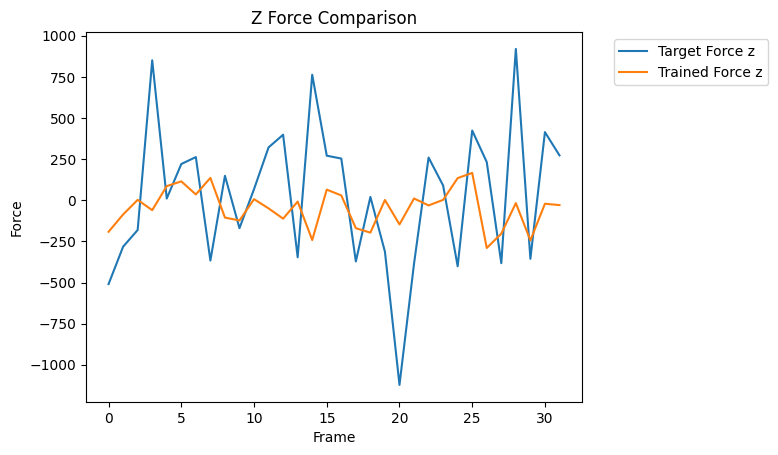

In [52]:
system.plotInitialForceGuess(to_frame=32)

<Figure size 1000x500 with 0 Axes>

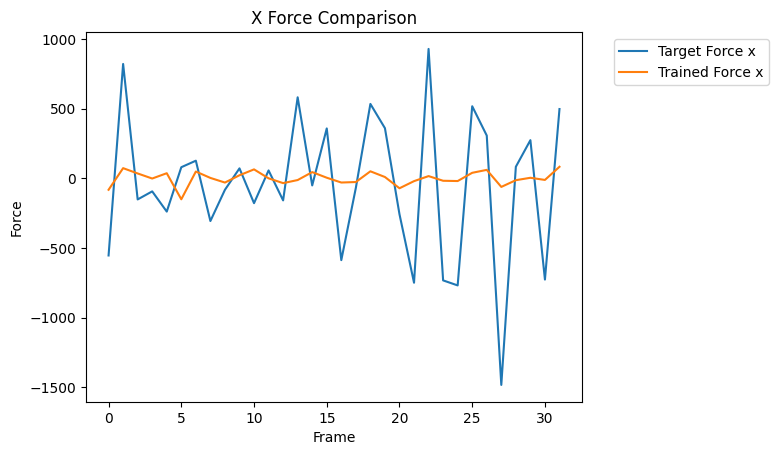

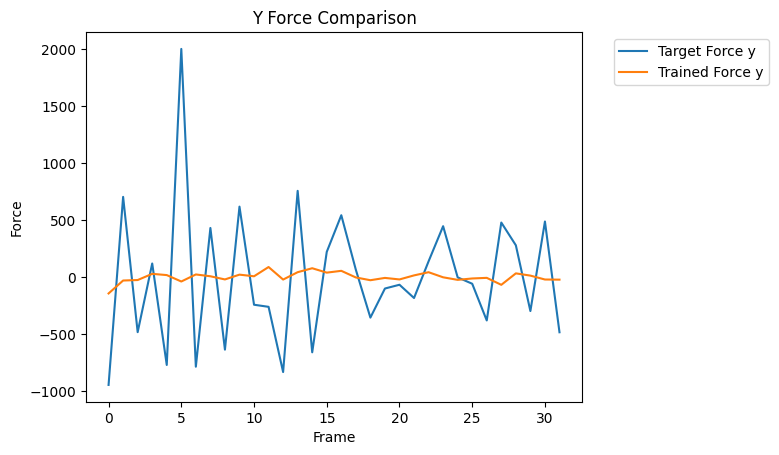

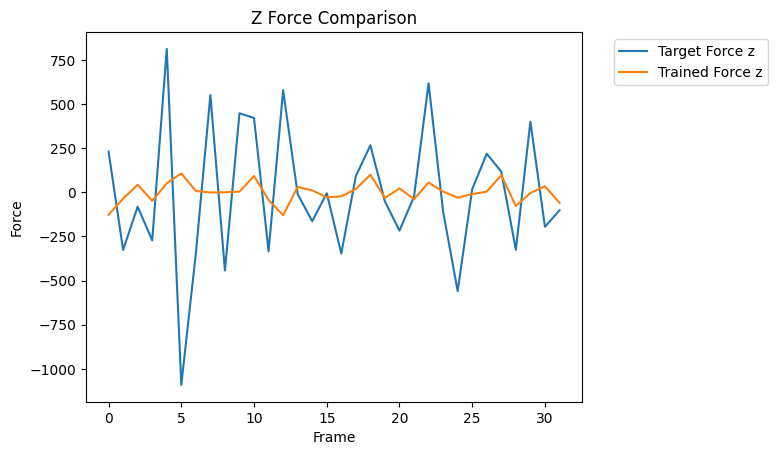

In [53]:
system.plotForceMathingByFrame(frame=0)

<Figure size 1000x500 with 0 Axes>

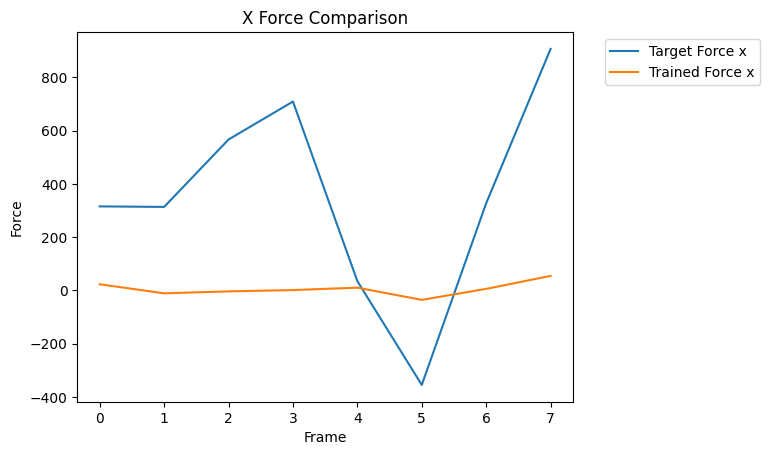

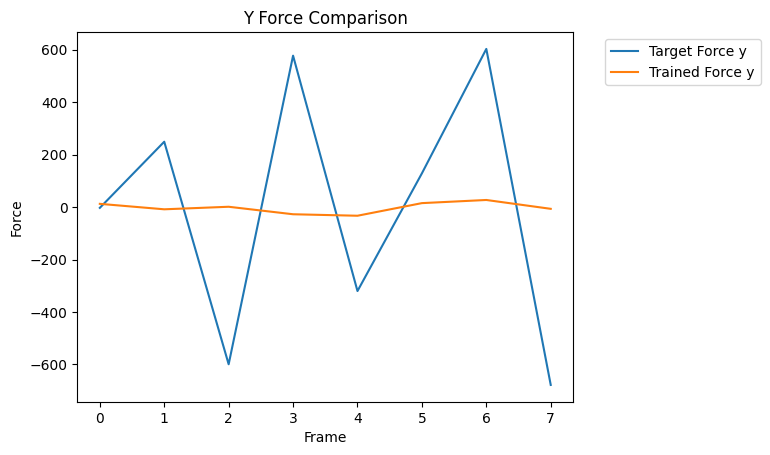

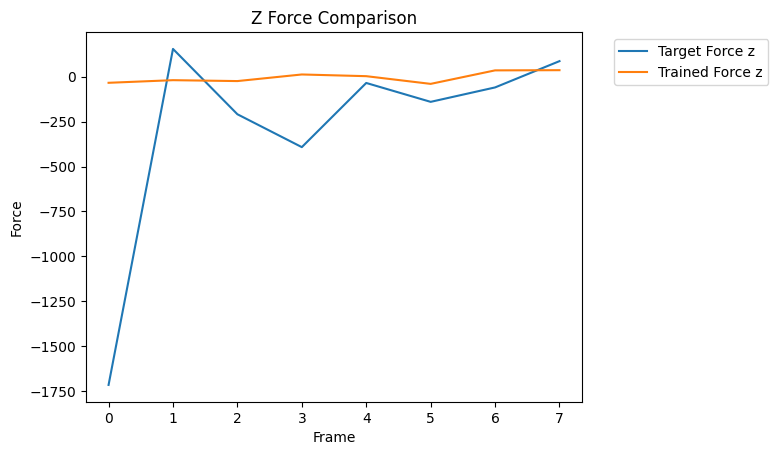

In [55]:
system.plotValForceMathing(bead_index=2, to_frame=8)

In [56]:
system.state_dict()

OrderedDict([('potential.bead_radii',
              tensor([0.1200, 0.2061, 0.1200, 0.1200, 0.1200, 0.1200, 0.1939, 0.1200, 0.1200,
                      0.1200, 0.1831, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
                      0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200, 0.1200,
                      0.1200, 0.1200, 0.1904, 0.1200, 0.2180, 0.1712, 0.1443, 0.1953, 0.2578,
                      0.1976, 0.2011, 0.2073, 0.1836, 0.1275], device='cuda:0')),
             ('potential.bead_types',
              tensor([ 1., 37., 38., 40., 39.,  1., 37., 38., 40., 39.,  1.,  6.,  1., 29.,
                       1., 10.,  1., 31.,  1.,  1., 31.,  1., 32., 33., 34., 36., 35.,  1.,
                      37., 38., 40., 39.], device='cuda:0')),
             ('potential.dispertion_const',
              tensor([-1.2834e-02, -3.8133e-03,  1.3559e-03,  1.6079e+00, -4.3500e-02,
                      -1.3484e-02,  3.4585e-03,  2.5754e+00,  3.2798e-02, -2.2636e+00,
  

In [33]:
mapping.save()

/home/enere@usi.ch/miniconda3/envs/CGffap/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/enere@usi.ch/miniconda3/envs/CGffap/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/enere@usi.ch/miniconda3/envs/CGffap/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'segids' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/enere@usi.ch/miniconda3/envs/CGffap/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/enere@usi.ch/miniconda